## <center>CITS5508 Lab sheet 4</center>

In [1]:
import pandas as pd
import numpy as np

## Data preprocessing

In [2]:
df_train = pd.read_csv('training.csv')
df_test = pd.read_csv('testing.csv')

def clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    return df[['class'] + [f'b{i}' for i in range(1, 10)]]

df_train = clean_cols(df_train)
df_test = clean_cols(df_test)

X_train, y_train = df_train[[f'b{i}' for i in range(1, 10)]], df_train['class']
X_test, y_test = df_test[[f'b{i}' for i in range(1, 10)]], df_test['class']

## Create a helper function

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

def helper_function(pipeline, param_grid):
    model = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv = StratifiedKFold(n_split=3, shuffle=True, random_state=42),
        scoring='f1_weighted',
        refit=True,
    )

    model.fit(X_train, y_train)

    print(f'optimal hyperparameter values: {model.best_params_}\n')

    cv_df = pd.DataFrame({
        'fold': range(1, 4),
        'Validation F1': [f'{model.cv_results_[f"split{i}_test_score"][model.best_index_]:.3f}' for i in range(3)]
    })

    print(cv_df.to_string(index=False) + '\n')

    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))

    print(f'Train accuracy: {train_accuracy:.3f}')
    print(f'Test accuracy: {test_accuracy:.3f}\n')

    ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=model.classes_,
    )
    plt.title('Test set')

    return model

## Task 1-4 Scaled SVC 标准化

optimal hyperparameter values: {'svc__C': 100.0, 'svc__kernel': 'linear'}

 fold Validation F1
    1         0.889
    2         0.915
    3         0.868

Train accuracy: 0.908
Test accuracy: 0.904



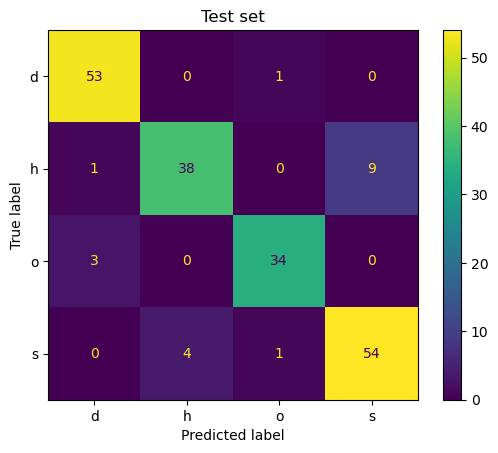

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

model_svc_scaled = helper_function(
    make_pipeline(MinMaxScaler(), SVC(decision_function_shape='ovo', random_state=42)),
    {
        'svc__C': np.logspace(-3, 3, 7),
        'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    },
)

## Task 5

optimal hyperparameter values: {'svc__C': 0.01, 'svc__kernel': 'linear'}

 fold Validation F1
    1         0.880
    2         0.925
    3         0.859

Train accuracy: 0.905
Test accuracy: 0.904



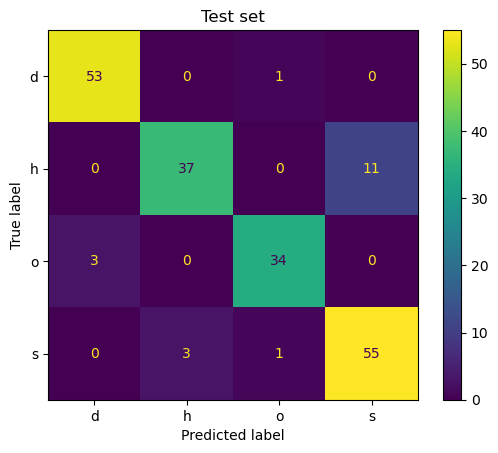

In [5]:
model_svc_unscaled = helper_function(
    make_pipeline(SVC(decision_function_shape='ovo', random_state=42)),
    {
        'svc__C': np.logspace(-3, 3, 7),
        'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    },
)

- The performance is actually very close here (`b1`, ..., `b9` are going to be on similar scales already).
- The feature scaled version is much faster to fit.

## Task 6

- SVMs are sensitive to feature scaling, but `b1`, ..., `b9` are on similar scales already
- The quadratic programming problem is much faster to solve after scaling
- In this case we *can* skip feature scaling if we're careful, but it certainly doesn't hurt to do it.

## Task 7

optimal hyperparameter values: {'logisticregression__C': 100.0, 'logisticregression__penalty': 'l2'}

 fold Validation F1
    1         0.871
    2         0.905
    3         0.869

Train accuracy: 0.902
Test accuracy: 0.909



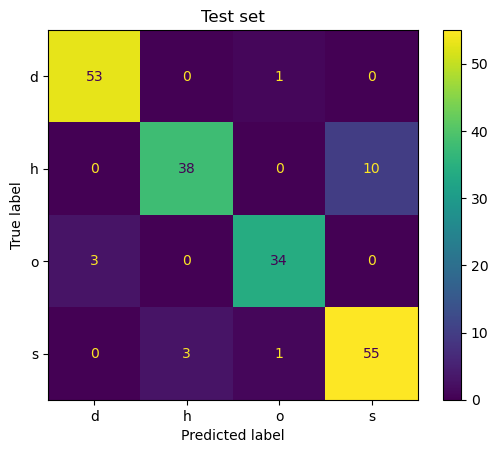

In [6]:
from sklearn.linear_model import LogisticRegression

# suppress warnings about penalty coefficients
import warnings
warnings.filterwarnings('ignore', message='Setting penalty=None will ignore the C and l1_ratio parameters')
warnings.filterwarnings('ignore', message="l1_ratio parameter is only used when penalty is 'elasticnet'.")

model_softmax = helper_function(
    make_pipeline(
        MinMaxScaler(), 
        LogisticRegression(max_iter=10000, random_state=42, l1_ratio=0.5, solver='saga')
    ),
    {
        'logisticregression__C': np.logspace(-3, 3, 7),
        'logisticregression__penalty': [None, 'l1', 'l2', 'elasticnet'],
    },
)

## Task 8

optimal hyperparameter values: {'kneighborsclassifier__n_neighbors': 15}

 fold Validation F1
    1         0.833
    2         0.895
    3         0.812

Train accuracy: 0.858
Test accuracy: 0.904



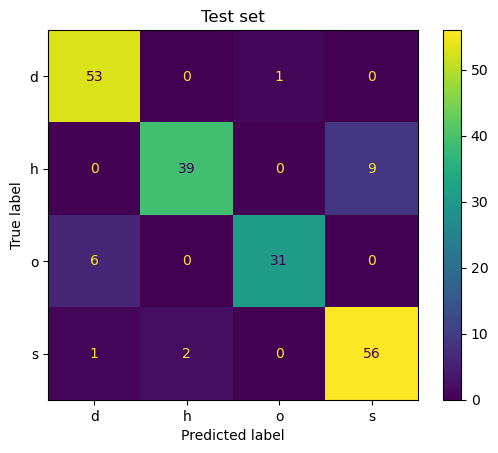

In [7]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = helper_function(
    make_pipeline(
        MinMaxScaler(), 
        KNeighborsClassifier()
    ),
    {
        'kneighborsclassifier__n_neighbors': np.linspace(1, 50, 11, dtype=int),
    },
)